# Data Pre-Processing

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from Electric_Vehicle_Prediction.configurations.mongo_db_connection import mongodb_client
from Electric_Vehicle_Prediction.constants import (
    MONGODB_DATABASE_NAME,
    MONGODB_COLLECTION_NAME,
)
import warnings
warnings.filterwarnings("ignore")

In [61]:
database = mongodb_client[MONGODB_DATABASE_NAME]
collection = database[MONGODB_COLLECTION_NAME]
data = collection.find({}, {"_id": 0, "index": 0})
df = pd.DataFrame(list(data))
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (231249, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,2T3YL4DV0E,King,Bellevue,WA,98005.0,2014,TOYOTA,RAV4,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,103.0,0.0,41.0,186450183,POINT (-122.1621 47.64441),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
1,5YJ3E1EB6K,King,Bothell,WA,98011.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0,1.0,478093654,POINT (-122.20563 47.76144),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
2,5UX43EU02S,Thurston,Olympia,WA,98502.0,2025,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,40.0,0.0,35.0,274800718,POINT (-122.92333 47.03779),PUGET SOUND ENERGY INC,5.306701e+10
3,JTMAB3FV5R,Thurston,Olympia,WA,98513.0,2024,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0,0.0,2.0,260758165,POINT (-122.81754 46.98876),PUGET SOUND ENERGY INC,5.306701e+10
4,5YJYGDEE8M,Yakima,Selah,WA,98942.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,236581355,POINT (-120.53145 46.65405),PACIFICORP,5.307700e+10


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232230 entries, 0 to 232229
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         232230 non-null  object 
 1   County                                             232226 non-null  object 
 2   City                                               232226 non-null  object 
 3   State                                              232230 non-null  object 
 4   Postal Code                                        232226 non-null  float64
 5   Model Year                                         232230 non-null  int64  
 6   Make                                               232230 non-null  object 
 7   Model                                              232230 non-null  object 
 8   Electric Vehicle Type                              232230 non-null  object

### Drop the columns which are not correalted to the target column

In [62]:
# List of columns to drop
drop_columns = [
    "VIN (1-10)",
    "Postal Code", 
    "Legislative District",
    "DOL Vehicle ID", 
    "2020 Census Tract", 
    "County", 
    "State", 
    "City", 
    "Electric Utility", 
    "Vehicle Location"
]

# Drop the specified columns
data = df.drop(columns=drop_columns)

In [63]:
data.head()

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP
0,2014,TOYOTA,RAV4,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,103.0,0.0
1,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0
2,2025,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,40.0,0.0
3,2024,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0,0.0
4,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0


## Data Cleaning

### Handling Missing values

* Handling Missing values 
* Handling Duplicates
* Check data type
* Understand the dataset

#### Check Null Values

In [6]:
##these are the features with nan value
features_with_na=[features for features in data.columns if data[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(data[feature].isnull().mean()*100,5), '% missing values')

Electric Range 0.01163 % missing values
Base MSRP 0.01163 % missing values


* A very small portion of the data contains null values. Therefore, I am removing them.

In [65]:
data.dropna(inplace=True)

In [66]:
data.isnull().sum()

Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232203 entries, 0 to 232229
Data columns (total 7 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Model Year                                         232203 non-null  int64  
 1   Make                                               232203 non-null  object 
 2   Model                                              232203 non-null  object 
 3   Electric Vehicle Type                              232203 non-null  object 
 4   Clean Alternative Fuel Vehicle (CAFV) Eligibility  232203 non-null  object 
 5   Electric Range                                     232203 non-null  float64
 6   Base MSRP                                          232203 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 14.2+ MB


### Other Data Cleaning steps

**Handling Duplicates**

In [10]:
data.duplicated().sum()

np.int64(231544)

* **No Duplicates in the dataset**

# Feature Engineering

### Type of Features

In [67]:
# define numerical & categorical columns
numerical_features = [feature for feature in data.columns if data[feature].dtype != 'O']
categorical_features = [feature for feature in data.columns if data[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numerical_features), numerical_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 3 numerical features : ['Model Year', 'Electric Range', 'Base MSRP']

We have 4 categorical features : ['Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']


## Feature Transformation

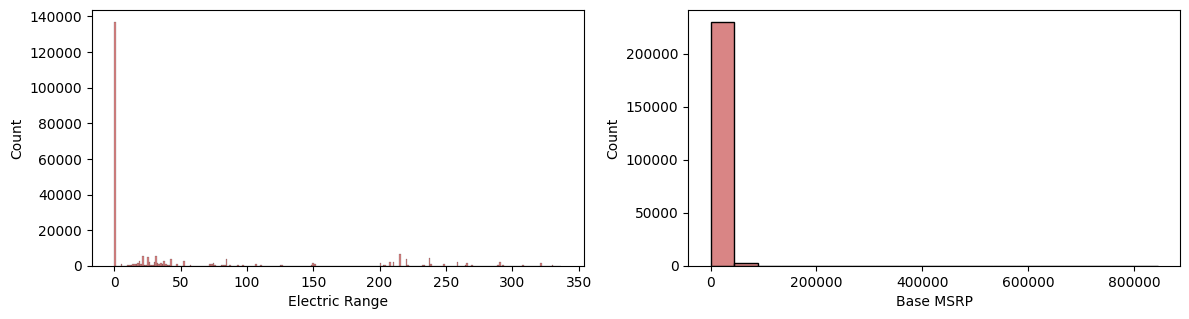

In [12]:
transform_features = ['Electric Range', 'Base MSRP']
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(transform_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(x=data[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [13]:
# Check Skewness
data[transform_features].skew(axis=0, skipna=True)

Electric Range     1.831307
Base MSRP         15.596547
dtype: float64

* Electric Range, Base MSRP, and DOL Vehicle ID column is skewed
* Apply a power transform featurewise to make data more Gaussian-like.

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

Currently, PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform.

### Apply Power Transformer to Check if it can reduces the outliers

In [14]:
from sklearn.preprocessing import PowerTransformer
transform_features = ['Electric Range', 'Base MSRP']
pt = PowerTransformer(method='yeo-johnson')
X_copy = pt.fit_transform(data[transform_features])

In [15]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)
X_copy.head()

,Electric Range,Base MSRP
0,1.298943,-0.119644
1,1.438560,-0.119644
2,1.075758,-0.119644
3,1.088781,-0.119644
4,-0.824442,-0.119644


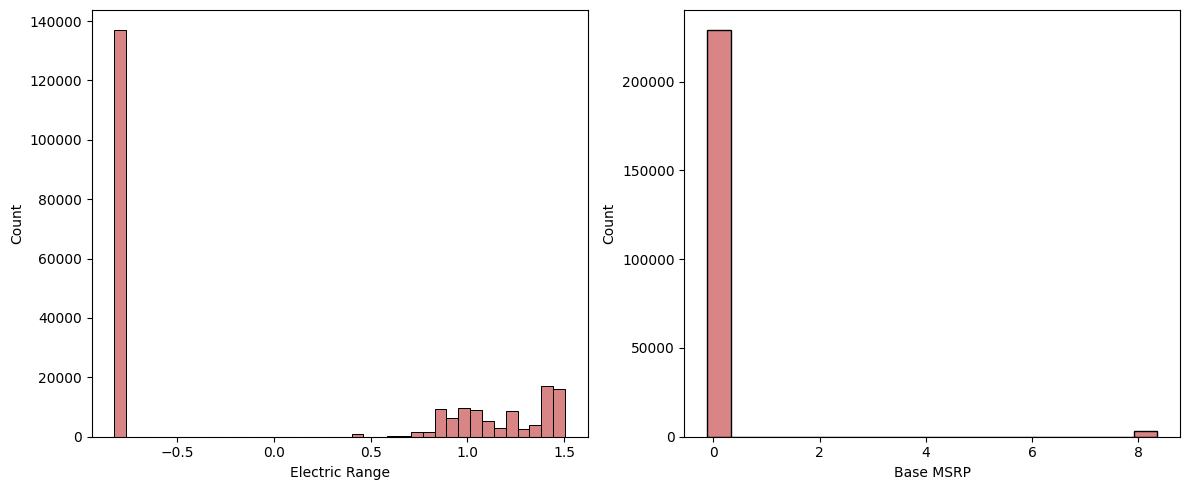

In [16]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, len(transform_features), i+1)
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

In [17]:
X_copy.skew(axis=0, skipna=True)

Electric Range    0.434306
Base MSRP         8.238543
dtype: float64

- Here Yeo-Johnson is used and it supports both positive or negative data for transformation.
- So Power Transformer with yeo-johnson can be used.

In [18]:
for feature in categorical_features:
    print(feature,':', data[feature].nunique())

Make : 46
Model : 170
Electric Vehicle Type : 2
Clean Alternative Fuel Vehicle (CAFV) Eligibility : 3


### Split X and Y

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “Electric Range” column.**

In [11]:
data.head()

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP
0,2014,TOYOTA,RAV4,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,103.0,0.0
1,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220.0,0.0
2,2025,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,40.0,0.0
3,2024,TOYOTA,RAV4 PRIME,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,42.0,0.0
4,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0


In [74]:
X = data.drop(columns=['Electric Range'])
y = data['Electric Range']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Preprocessing using Column Transformer**

In [76]:
# Create Column Transformer with 3 types of transformers
or_columns = ['Electric Vehicle Type']
oh_columns = ['Make', 'Model', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']
num_features = ['Model Year', 'Base MSRP']

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer 

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [77]:
X_train_scal = preprocessor.fit_transform(X_train)
X_test_scal = preprocessor.transform(X_test)

In [78]:
X_train_scal.shape, y_train.shape

((184977, 197), (184977,))

In [79]:
print(type(X_train_scal))

<class 'numpy.ndarray'>


# Regression

## Train Test Split
- The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

- It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [71]:
X = data.drop(columns=['Electric Range'])
y = data['Electric Range']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
X_train.shape, X_test.shape

((184977, 6), (46245, 6))

In [73]:
X_train

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Base MSRP
118530,2021,NISSAN,LEAF,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0
66675,2023,FORD,F-150,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0
218983,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,0.0
33593,2019,VOLKSWAGEN,E-GOLF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,0.0
36775,2012,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,0.0
...,...,...,...,...,...,...
119899,2025,RIVIAN,R1S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0
103711,2022,FORD,F-150,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0
131953,2024,MAZDA,CX-90,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,0.0
146888,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0


## Baseline Model

In [44]:
# Baseline Model (Dummy Regressor)
dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

In [45]:
# Evaluate Baseline Model
dummy_mse = mean_squared_error(y_test, y_pred_dummy)
dummy_r2 = r2_score(y_test, y_pred_dummy)
print(f"Baseline Model - MSE: {dummy_mse:.2f}, R2 Score: {dummy_r2:.2f}")

Baseline Model - MSE: 7054.69, R2 Score: -0.00


## Machine Learning Model

In [46]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    print(f"{name} - Cross-Validation R2 Score: {np.mean(scores):.2f}")


Linear Regression - Cross-Validation R2 Score: 0.95
Random Forest - Cross-Validation R2 Score: 1.00


## Model Training 

In [20]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models, preprocessor):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # Transform the data using preprocessor
    X = preprocessor.fit_transform(X)

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    r_square_value= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        r_squared_train = r2_score(y_train, y_train_pred)
        mse_train = mean_squared_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mse_train)
        model_train_accuracy = 1 - (rmse_train / np.mean(y_train))


        # Test set performance
        r_squared_test = round(r2_score(y_test, y_test_pred),2)
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mse_test)
        model_test_accuracy = round(1 - (rmse_test / np.mean(y_test)),2)
        r_square_value.append(r_squared_test)
        accuracy_list.append(model_test_accuracy)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print('- R2 score: {:.2f}'.format(r_squared_train))
        print('- MSE: {:.2f}'.format(mse_train))
        print('- RMSE: {:.2f}'.format(rmse_train))
        print('- Accuracy: {:.2f}'.format(model_train_accuracy))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- R2 score: {:.2f}'.format(r_squared_test))
        print('- MSE: {:.2f}'.format(mse_test))
        print('- RMSE: {:.2f}'.format(rmse_test))
        print('- Accuracy: {:.2f}'.format(model_test_accuracy))
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list, r_square_value)), columns=['Model Name', 'Accuracy', 'R Square Value']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

In [21]:
models = {
    "Linear Regression": LinearRegression(),
    # "SVR": SVR(kernel='linear'),  # Uncomment if you want to include SVR (Runtime too long)
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

In [22]:
base_model_report = evaluate_models(X=X, y=y, models=models, preprocessor=preprocessor)

Linear Regression
Model performance for Training set
- R2 score: 0.95
- MSE: 386.62
- RMSE: 19.66
- Accuracy: 0.58
----------------------------------
Model performance for Test set
- R2 score: 0.95
- MSE: 378.73
- RMSE: 19.46
- Accuracy: 0.58


Decision Tree
Model performance for Training set
- R2 score: 1.00
- MSE: 13.84
- RMSE: 3.72
- Accuracy: 0.92
----------------------------------
Model performance for Test set
- R2 score: 1.00
- MSE: 12.55
- RMSE: 3.54
- Accuracy: 0.92


KNN
Model performance for Training set
- R2 score: 1.00
- MSE: 15.83
- RMSE: 3.98
- Accuracy: 0.92
----------------------------------
Model performance for Test set
- R2 score: 1.00
- MSE: 14.35
- RMSE: 3.79
- Accuracy: 0.92


Random Forest
Model performance for Training set
- R2 score: 1.00
- MSE: 13.85
- RMSE: 3.72
- Accuracy: 0.92
----------------------------------
Model performance for Test set
- R2 score: 1.00
- MSE: 12.55
- RMSE: 3.54
- Accuracy: 0.92


XGBoost
Model performance for Training set
- R2 score:

**Results of All Models**

In [23]:
base_model_report

,Model Name,Accuracy,R Square Value
1,Decision Tree,0.92,1.00
3,Random Forest,0.92,1.00
2,KNN,0.92,1.00
4,XGBoost,0.92,1.00
0,Linear Regression,0.58,0.95


**Observations:**

- Linear Regression has noticeably lower accuracy (0.58) and higher error values (MSE and RMSE), making it the least optimal choice among these models.
- Tree-based models (Decision Tree, Random Forest, XGBoost) and KNN show excellent performance in both training and test sets.
- KNN is also performing well, but may struggle with scalability if applied to large datasets.
- Random Forest & XGBoost tend to offer better generalization compared to Decision Trees, reducing overfitting risks.

### Hyperparameter Tuning

**Here we can use XGBoost & Random Forest for Hyper Parameter Tuning**

**Define the parameter distribution for XGBoost & Random forest**

In [45]:
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

In [46]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBRegressor(), xgboost_params),
]

**Create a function for model training and report which can be used in hyperparameter tuning loop**

In [47]:
# Transform the data using preprocessor
X_train_scal = preprocessor.fit_transform(X_train)
model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=10,
        cv=3,
        verbose=2,
        n_jobs=-1
    )
    random.fit(X_train_scal, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
---------------- Best Params for XGBoost -------------------
{'min_child_weight': 1, 'max_depth': 7}


In [48]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 7}}

In [55]:
rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

In [56]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ("RF", RandomForestRegressor(), rf_params),
]

In [57]:
# Transform the data using preprocessor
X_train_scal = preprocessor.fit_transform(X_train)
model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=10,
        cv=3,
        verbose=2,
        n_jobs=-1
    )
    random.fit(X_train_scal, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
---------------- Best Params for RF -------------------
{'n_estimators': 100, 'max_features': None, 'max_depth': 20}


In [58]:
model_param

{'RF': {'n_estimators': 100, 'max_features': None, 'max_depth': 20}}

## Retraining the Model with best Parameters

In [ ]:
# from sklearn.metrics import roc_auc_score,roc_curve
# best_models = {
#     "Random Forest Classifier": RandomForestRegressor(**model_param['RF']),
#     "XGBClassifier": XGBRegressor(**model_param['XGBoost'],n_jobs=-1),
# }
# tuned_report =evaluate_models(X=X_train, y=y_train, models=best_models)

In [52]:
best_model = XGBRegressor(**model_param['XGBoost'])
X_train_scal = preprocessor.fit_transform(X_train)
best_model = best_model.fit(X_train_scal,y_train)
X_test_scal = preprocessor.transform(X_test)
y_pred = best_model.predict(X_test_scal)
r_squared_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
model_test_accuracy = 1 - (rmse_test / np.mean(y_test))

print('Model performance for Test set')
print('- R2 score: {:.2f}'.format(r_squared_test))
print('- MSE: {:.2f}'.format(mse_test))
print('- RMSE: {:.2f}'.format(rmse_test))
print('- Accuracy: {:.2f}'.format(model_test_accuracy))

Model performance for Test set
- R2 score: 1.00
- MSE: 12.57
- RMSE: 3.55
- Accuracy: 0.92


In [59]:
best_model = RandomForestRegressor(**model_param['RF'])
X_train_scal = preprocessor.fit_transform(X_train)
best_model = best_model.fit(X_train_scal,y_train)
X_test_scal = preprocessor.transform(X_test)
y_pred = best_model.predict(X_test_scal)
r_squared_test = r2_score(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
model_test_accuracy = 1 - (rmse_test / np.mean(y_test))

print('Model performance for Test set')
print('- R2 score: {:.2f}'.format(r_squared_test))
print('- MSE: {:.2f}'.format(mse_test))
print('- RMSE: {:.2f}'.format(rmse_test))
print('- Accuracy: {:.2f}'.format(model_test_accuracy))

Model performance for Test set
- R2 score: 1.00
- MSE: 12.56
- RMSE: 3.54
- Accuracy: 0.92


## Best Model is XGBoost with Accuracy 92%

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='linear'),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    print(f"{name} - Cross-Validation R2 Score: {np.mean(scores):.2f}")
